In [1]:
import pandas as pd
import scipy.stats as sps
import numpy as np
from collections import defaultdict
import psycopg2
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import copy
from math import log

In [2]:
projects = ['ru.stackoverflow.com','datascience.stackexchange.com','arduino.stackexchange.com',
            'cstheory.stackexchange.com','sqa.stackexchange.com','softwareengineering.stackexchange.com',
            'stats.stackexchange.com', 'ai.stackexchange.com','cseducators.stackexchange.com']

In [3]:
# отправить SQL запрос в нашу БД
def data_request(request):
    connection = psycopg2.connect(dbname='sinya', user='postgres', 
                        password='11111', host='127.0.0.1')
    cursor = connection.cursor()
    cursor.execute(request)
    records = cursor.fetchall()
    cursor.close()
    connection.close()
    return records

def split_tags(string):
    raw_tags = re.findall('<.*?>', string) 
    tags = [re.sub(r'<(.*?)>', r'\1', tag) for tag in raw_tags ]
    return tags


# разбить список тегов на отдельные, построить словарь частот
def dict_of_tags(data,split_fun = split_tags):
    d = defaultdict(int)
    for unit in data:
        if unit[0]:
            for tag in split_fun(unit[0]):
                d[tag] +=1
    return d


#выбрать из словаря самые популярные
def list_of_popular_tags(dictionary, top = 5):
    tags = list(dictionary.items())
    tags.sort(key=lambda p: -p[1])
    return tags[:top]




In [7]:
def plot_hist_top_n(top_n, project_id, ylabel, xlabel = 'Tags',period = 'all time'):
    names,counts = zip(*top_n)
    plt.figure(figsize=[15, 7])
    plt.title(f'Top {top} {xlabel} in Posts on {projects[project_id-1]} per {period}', fontsize=20)
    plt.ylabel(ylabel, fontsize=15)
    plt.xlabel(xlabel, fontsize=15)
    plt.xticks(rotation=65)
    plt.bar(names,counts, width=0.9)
    plt.show()

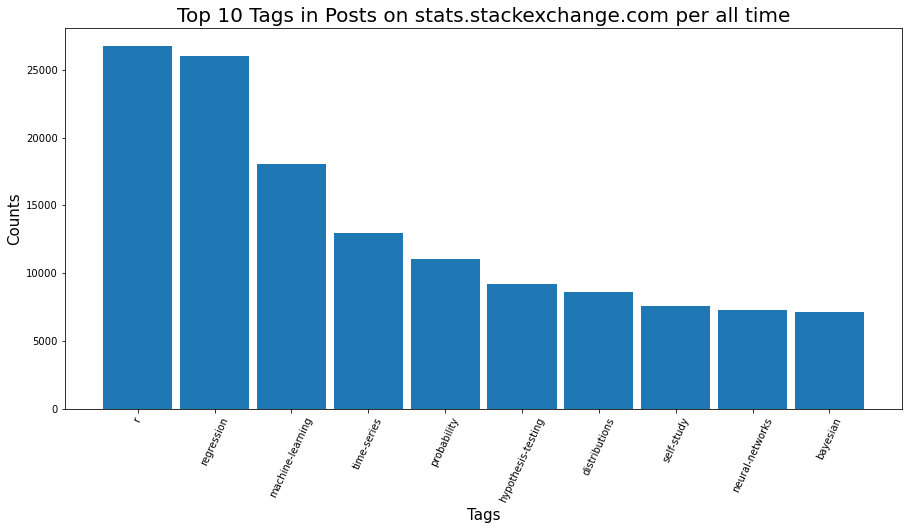

In [8]:
# самые популярные теги проекта за всю историю по числу постов

# выберите проект и число самых популярных тегов для просмотра
project_id = 7
top = 10

data = data_request(f'SELECT "Tags" FROM public.posts WHERE "ProjectId" = {project_id} AND "Tags" IS NOT NULL;')
top_10 = list_of_popular_tags(dict_of_tags(data),top)
plot_hist_top_n(top_10, project_id, ylabel = "Counts")

In [10]:
# вес тега = view_count/число дней существования поста


# разбить список тегов на отдельные, построить словарь весов
def weight_dict_of_tags(data,pub_date, split_fun = split_tags):
    d = defaultdict(float)
    for unit in data:
        if unit[0] is not None:
            view_count = unit[1]
            life_time = (pub_date  - unit[2].date())/ timedelta(days = 1)
            weight = view_count/life_time
            for tag in split_fun(unit[0]):
                d[tag] +=weight
    return d




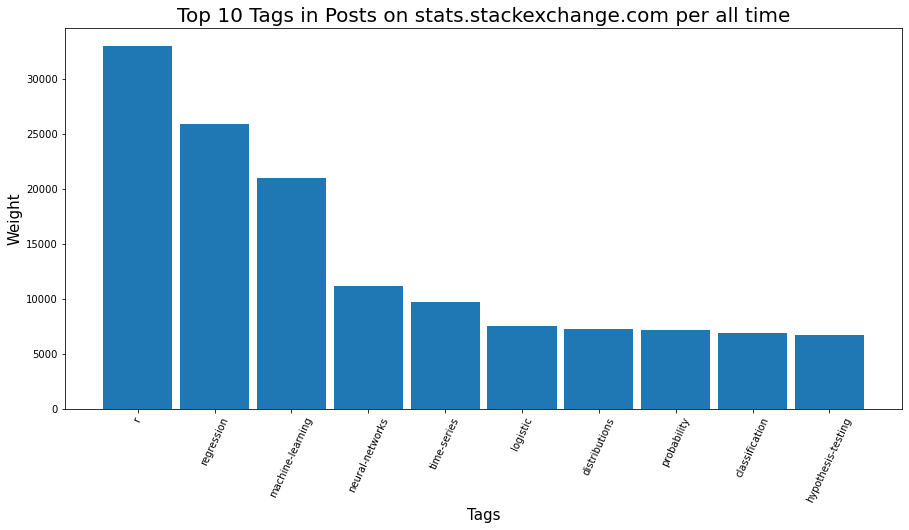

In [12]:
# # самые популярные теги проекта за всю историю по весу

project_id = 7
top = 10

data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} ;')
pub_date = data_request(f'SELECT "publication_date" FROM projects WHERE "id" = {project_id} ;')[0][0]
top_10 = list_of_popular_tags(weight_dict_of_tags(data,pub_date),top)
plot_hist_top_n(top_10, project_id, ylabel = 'Weight')

In [13]:
def plot_2_hist(project_id,tags,first,second,first_label,second_label):
    # Visualizing the data with multiple bar chart
    plt.figure(figsize=[15, 9])

    # Set the width of the bars
    wd = 0.7
    x_pos = np.arange(1, 2*len(tags), 2)

    # Plotting the multiple bar graphs on the same figure
    plt.bar(x_pos, first, color='r', width=wd, edgecolor='k',
        label=first_label)
    plt.bar(x_pos+wd, second, color='b', width=wd, edgecolor='k', 
        label=second_label)

    # Add xticks
    plt.xticks(x_pos+wd, tags, fontsize=15, rotation=80)
    plt.yticks(fontsize=15)
    plt.title(f'Top {len(top_100)} Tags in Posts on {projects[project_id-1]}', fontsize=20)
    plt.xlabel('Tags', fontsize=17)
    plt.ylabel('', fontsize=17)

    plt.legend(loc='upper center', fontsize=15)
    plt.show()

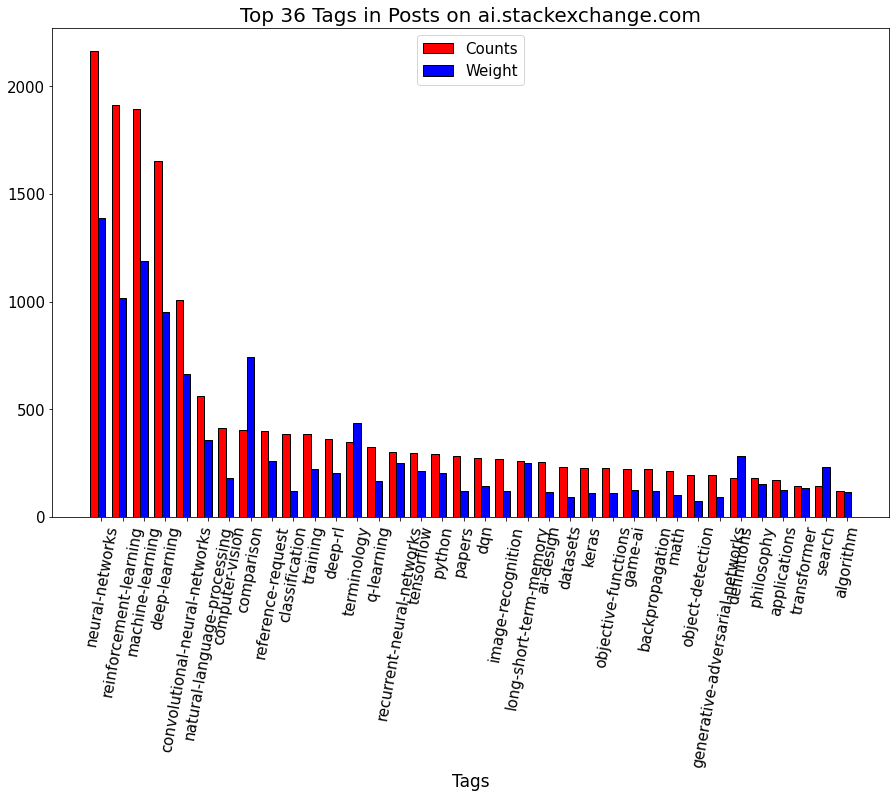

In [14]:
# сравнение популярности топ50+топ 50 тегов по весу и числу

project_id = 8
top = 30

data = data_request(f'SELECT "Tags" FROM public.posts WHERE "ProjectId" = {project_id} AND "Tags" IS NOT NULL;')
dict_counts = dict_of_tags(data)
top_50_counts = list_of_popular_tags(dict_counts,top)
tags_count,_ = zip(*top_50_counts)

data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} ;')
pub_date = data_request(f'SELECT "publication_date" FROM projects WHERE "id" = {project_id} ;')[0][0]
dict_weights = weight_dict_of_tags(data,pub_date)
top_50_weight = list_of_popular_tags(dict_weights,top)
tags_weight,_ = zip(*top_50_weight)

top_100 = set.union(set(tags_count),set(tags_weight))

tags = sorted(list(top_100),key = lambda x: -dict_counts[x])
counts = [dict_counts[tag] for tag in tags]
weights = [dict_weights[tag] for tag in tags]

plot_2_hist(project_id,tags,counts,weights,'Counts','Weight')

In [15]:
# возвращает словарь весов тегов, посчитанных на постах созданных за указанный период

def w_tags_per_period(project_id,start_date,final_date):
    pub_date = data_request(f'SELECT "publication_date" FROM projects WHERE "id" = {project_id} ;')[0][0]
    data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM posts' +  
                        f' WHERE "ProjectId" = {project_id} AND "CreationDate" > \'{start_date}\' '+
                        f' AND "CreationDate" < \'{final_date}\' ;')
    return weight_dict_of_tags(data,pub_date)
        

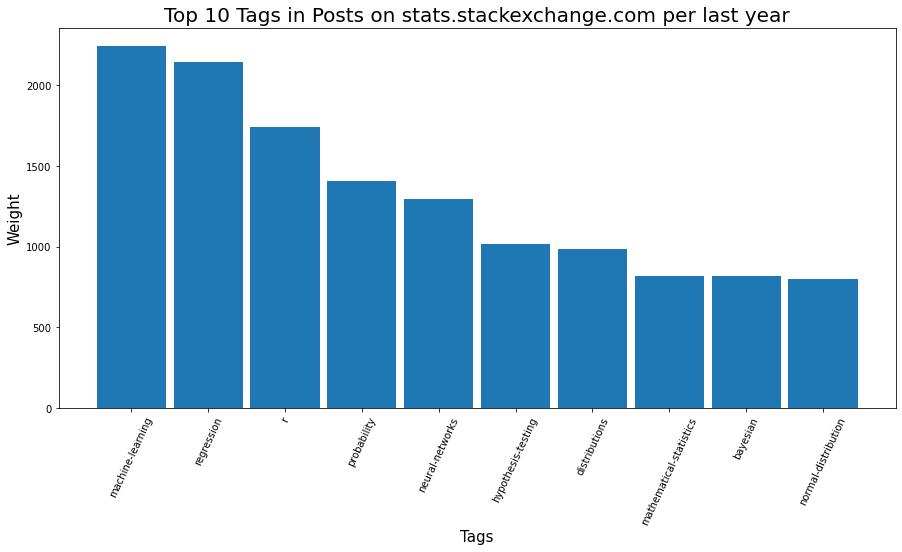

In [19]:
# самые популярные по весу теги за последний год
project_id = 7
top = 10

cur_year = w_tags_per_period(project_id, start_date = '2021-03-01',final_date = '2022-03-01')
top_10 = list_of_popular_tags(cur_year,10)
plot_hist_top_n(top_10, project_id, ylabel = 'Weight', period = 'last year')

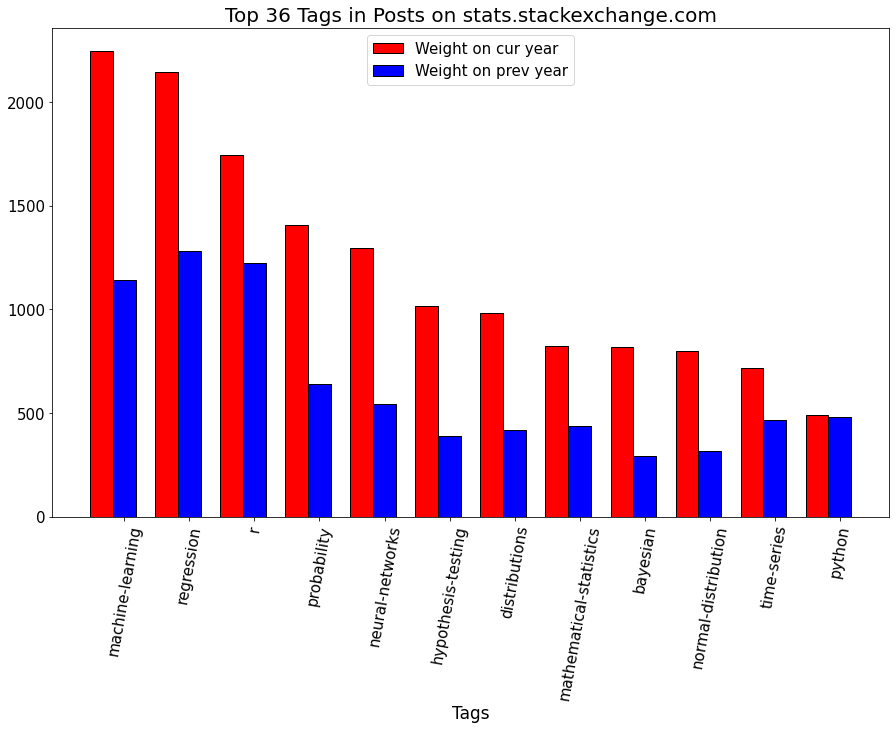

In [24]:
# посмотрим отношение прироста веса тега, посчитанного за этот год и за прошлый год 

project_id = 7
top = 10

cur_year = w_tags_per_period(project_id, start_date = '2021-03-01',final_date = '2022-03-01')
last_year = w_tags_per_period(project_id, start_date = '2020-03-01',final_date = '2021-03-01')

cur_year_popular = list_of_popular_tags(cur_year,top)
last_year_popular = list_of_popular_tags(last_year,top)

tags_cur_year,_ = zip(*cur_year_popular)
tags_last_year,_ = zip(*last_year_popular)

top_union = set.union(set(tags_cur_year),set(tags_last_year))

tags = sorted(list(top_union),key = lambda x: -cur_year[x])
cur_year_cnts = [cur_year[tag] for tag in tags]
last_year_cnts = [last_year[tag] for tag in tags]


plot_2_hist(project_id,tags,cur_year_cnts,last_year_cnts,'Weight on cur year','Weight on prev year')

Наибольшая метрика [('p-hacking', 144345.80744843755), ('linear-dynamical-system', 19000.59521428803), ('parametric', 14985.98668089544), ('mixed-random-variable', 13585.444321835308), ('rating', 8770.587121342523), ('archaeology', 8595.964912280702), ('highest-density-region', 4773.422876699112), ('geometric-mean', 4410.193027188694), ('jarowinkler-distance', 4360.198624904508), ('hamming-distance', 4193.592433472956)]


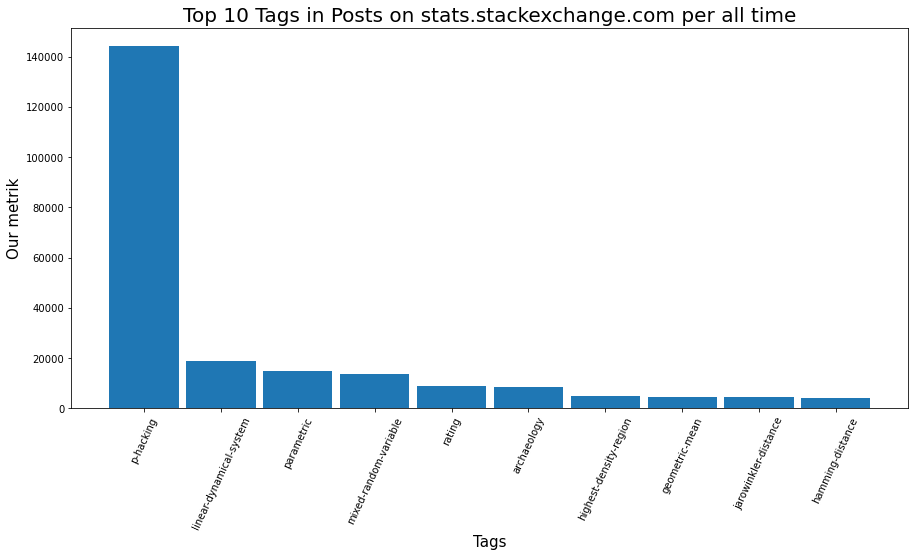

In [27]:
# Наша метрика3 = (вес за этот год - вес за прошлый год)/вес за прошлый год

project_id = 7
top = 10


metric ={}
for tag in cur_year.keys():
    if (tag in last_year.keys()) and (last_year[tag] != 0) :   # надо обсудить!!!!!
        metric[tag] = (cur_year[tag]-last_year[tag])/last_year[tag]*100

metric_popular = list_of_popular_tags(metric,top)
print('Наибольшая метрика',metric_popular)
plot_hist_top_n(metric_popular, project_id, ylabel = 'Our metric')



In [28]:
# а сколько всего раз их упоминали?
data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} ;')
d = dict_of_tags(data)

tags,_ = zip(*metric_popular)
for tag in tags:
    print(tag,d[tag])
    
# оказывается страшно мало, для каких-то выводов

p-hacking 12
linear-dynamical-system 38
parametric 17
mixed-random-variable 8
rating 133
archaeology 7
highest-density-region 24
geometric-mean 68
jarowinkler-distance 2
hamming-distance 4


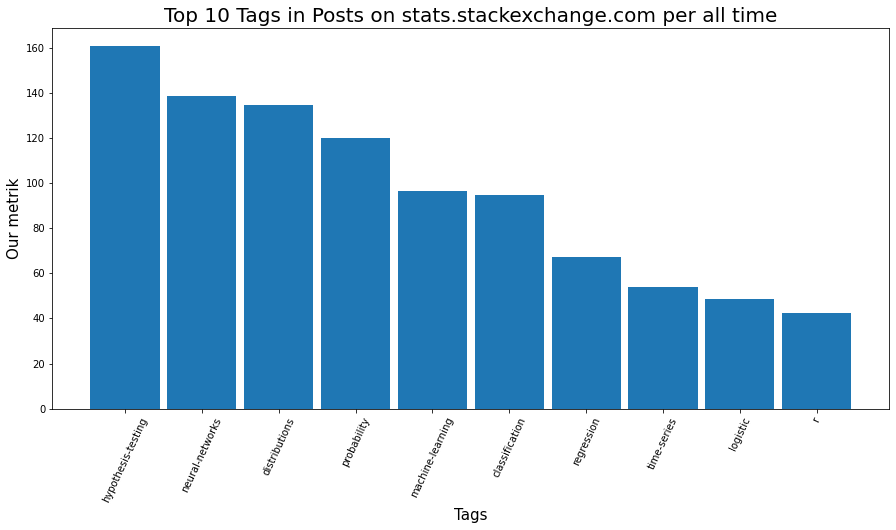

In [30]:
# тогда посмотрим у кого из топ-100 по весу наибольшая метрика 3

data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} ;')
pub_date = data_request(f'SELECT "publication_date" FROM projects WHERE "id" = {project_id} ;')[0][0]
top_100 = list_of_popular_tags(weight_dict_of_tags(data,pub_date),top)
tags_100,_ = zip(*top_100)

metric_sufficient = {}
for tag in tags_100:
    metric_sufficient[tag] = metric[tag]
    
metric_popular = list_of_popular_tags(metric_sufficient,top)
plot_hist_top_n(metric_popular, project_id, ylabel = 'Our metric_3')


In [31]:
# проверим, что теперь их упоминали достаточно

data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} ;')
d = dict_of_tags(data)

tags,_ = zip(*metriс_popular)
for tag in tags:
    print(tag,d[tag])

hypothesis-testing 9227
neural-networks 7277
distributions 8590
probability 11025
machine-learning 18068
classification 6303
regression 26055
time-series 12965
logistic 7015
r 26743


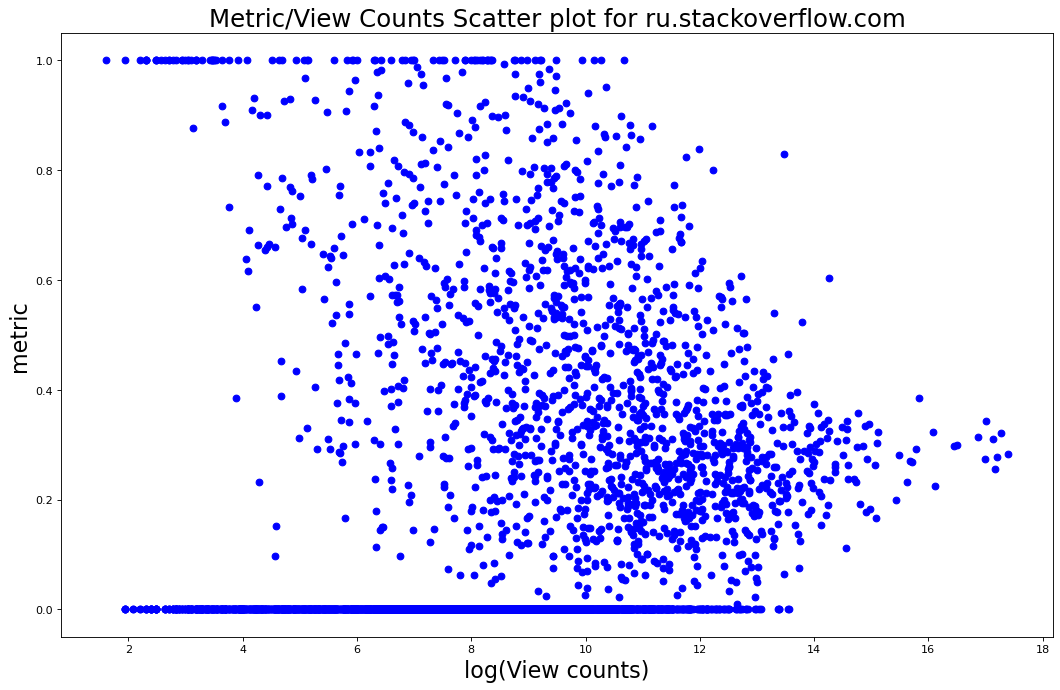

In [65]:
# построим диаграмму рассеивания (веса за месяц)/вес за год?
# уточнить правильно ли и это поняла!! 
project_id = 1

year = w_tags_per_period(project_id, start_date = '2021-03-01',final_date = '2022-03-01')
month = w_tags_per_period(project_id,start_date = '2022-02-01',final_date = '2022-03-01')

metric ={}
for tag in year.keys():
    if year[tag] != 0:   
        metric[tag] = month[tag]/year[tag]

data = data_request(f'SELECT "Tags","ViewCount" FROM public.posts WHERE "ProjectId" = {project_id} ;')

view_counts = defaultdict(float)
for unit in data:
    if unit[0] is not None:
        for tag in split_tags(unit[0]):
            view_counts[tag] += unit[1]
            
tags = list(metric.keys())
points = [[view_counts[tag],metric[tag]] for tag in tags]

plt.subplots(figsize=(16,10), dpi= 80)  
for i in range(len(tags)):
    x = points[i][0]
    y = points[i][1]
    name = tags[i]
    plt.plot(log(x), y, 'bo')
    # можно включить подписи, в середине будет грязь, зато по краям понятно кто
    #plt.text(x * (1 + 0.02), y * (1 + 0.03) , name, fontsize=12)

plt.ylabel('metric',fontsize=20)
plt.xlabel('log(View counts)',fontsize=20)
plt.title(f'Metriс/View Counts Scatter plot for {projects[project_id-1]}', fontsize=22)
plt.show()

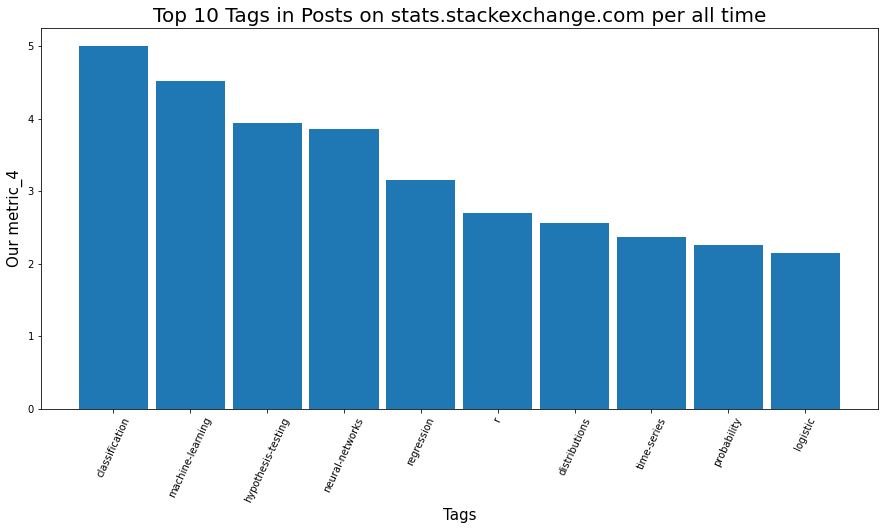

In [84]:
# Наша метрика4 = вес за этот месяц/средний вес за месяц, усредненный за последний год

project_id = 7
top = 10


cur_month = w_tags_per_period(project_id, start_date = '2022-02-01',final_date = '2022-03-01')
# to do: автоматическую генерацию этого списка
months = ['2022-03-01','2022-02-01','2022-01-01','2021-12-01','2021-11-01','2021-10-01',
         '2021-09-01','2021-08-01','2021-07-01','2021-06-01','2021-05-01','2021-04-01','2021-03-01']

average_month = defaultdict(int)

final_date = months[0]
for i in range(1,13):
    start_date = months[i]
    month = w_tags_per_period(project_id,start_date,final_date)
    for tag in month.keys():
        average_month[tag] += (month[tag]/12)
    final_date = start_date
    
# может быть правильнее сделать вес за каждый день, а потом скользящее среднее по периоду в 30 дней?

metric ={}
for tag in cur_month.keys():
    metric[tag] = (cur_month[tag] - average_month[tag])/average_month[tag]

    
    
# опять посмотрим у кого из топ-100 по весу наибольшая метрика 3

data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} ;')
pub_date = data_request(f'SELECT "publication_date" FROM projects WHERE "id" = {project_id} ;')[0][0]
top_100 = list_of_popular_tags(weight_dict_of_tags(data,pub_date),top)
tags_100,_ = zip(*top_100)

metric_sufficient = {}
for tag in tags_100:
    metric_sufficient[tag] = metric[tag]
    
metric_popular = list_of_popular_tags(metric_sufficient,top)
plot_hist_top_n(metric_popular, project_id, ylabel = 'Our metric_4')

In [49]:
# Переходим к анализу заголовков

# чистим слова от слишком популярных и стоп слов
def purify(dictionary):
    trash = trash_set()
    for word in copy.deepcopy(dictionary).keys():
        if word.lower() in trash:
            del dictionary[word]
        else:
            dictionary[word.lower()] = dictionary.pop(word)
        
    return dictionary

def trash_set():
    common = []
    with open('/Users/sinya/JB_practice/vocabular.txt', 'r', encoding='utf8') as f: 
        soup = BeautifulSoup(f)
        text = soup.get_text()
        # break into lines and remove leading and trailing space on each
        for line in text.splitlines():
             common += line.strip().split()
            
                
                    
    # build collections of words we need to delete
    english_stopwords = set(stopwords.words("english"))
    russian_stopwords = set(stopwords.words("russian"))
    common_words = set(common)
    specials = set(list(',./?":*(){}[]$``\'<>'))
    
    return english_stopwords | common_words | russian_stopwords | specials



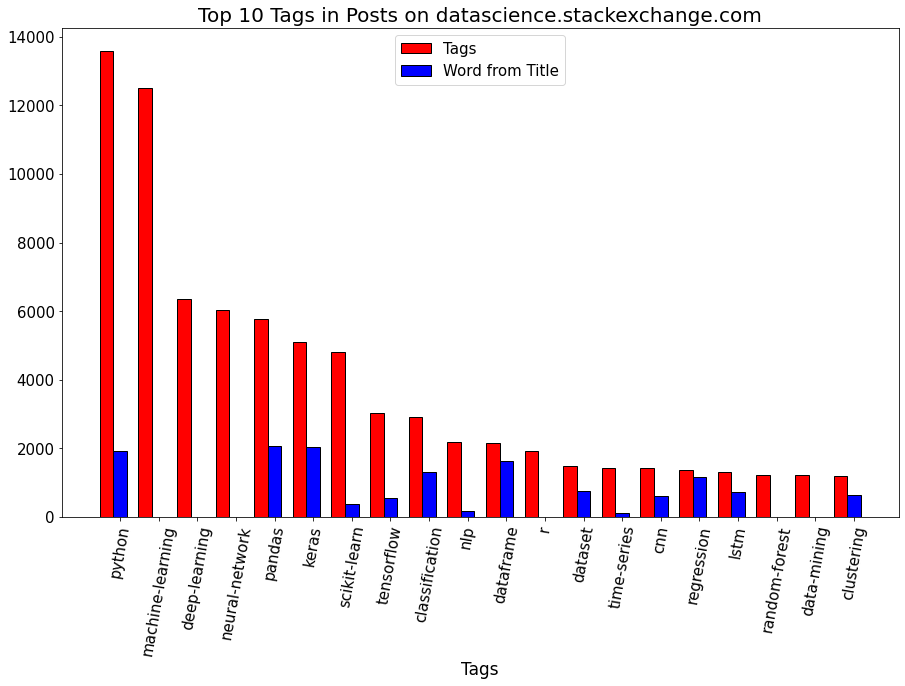

In [50]:
# сравнение веса по тегу и по такому же слову в заголовке среди топ по тегу
project_id = 2
top = 20

data = data_request(f'SELECT "Title","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} AND "Title" IS NOT NULL;')
pub_date = data_request(f'SELECT "publication_date" FROM projects WHERE "id" = {project_id} ;')[0][0]
dict_title = weight_dict_of_tags(data,pub_date,split_fun = lambda x: [el.lower() for el in x.split()])
# можно использовать nltk.word_tokenize(x), тогда вместе считаются python и python?, но и C и С#
top_title = list_of_popular_tags(purify(dict_title),top)

data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} ;')
dict_tags = weight_dict_of_tags(data,pub_date)
top_tags = list_of_popular_tags(dict_tags,top)

tags, _ = zip(*top_tags)

tag_arr = [dict_tags[tag] for tag in tags]
title_arr = [dict_title[tag] for tag in tags]

plot_2_hist(project_id,tags,tag_arr,title_arr,'Tags','Word from Title')

In [ ]:
def split_to_ngrams(title, n, trash):
    # тут уже точно нормально tokenize, просто с# станет биграммой и ладно
    words = [w.lower() for w in nltk.word_tokenize(title) if w not in trash] 
    ngrams = list(nltk.ngrams(words, n))
    return ngrams



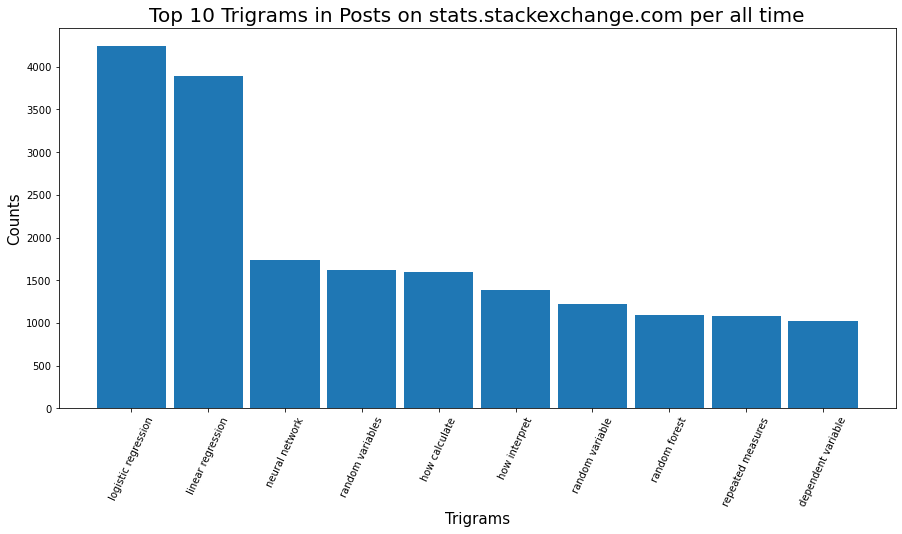

In [64]:
# поищем самые популярные биграммы и триграммы по counts

project_id = 7
top = 10

data = data_request(f'SELECT "Title" FROM public.posts WHERE "ProjectId" = {project_id} AND "Title" IS NOT NULL;')
trash = trash_set()
d = dict_of_tags(data, split_fun = lambda x: split_to_ngrams(x, 2, trash))
top_10 = list_of_popular_tags(d,top)

# танцы с бубном, чтобы избавиться от всевозможных tuple 
def reform(top_n):
    top = top = [list(el) for el in top_n]
    for i,pair in enumerate(top):
        top[i][0] = " ".join(pair[0])
    return top

plot_hist_top_n(reform(top_10), project_id, ylabel = "Counts", xlabel = 'Trigrams')

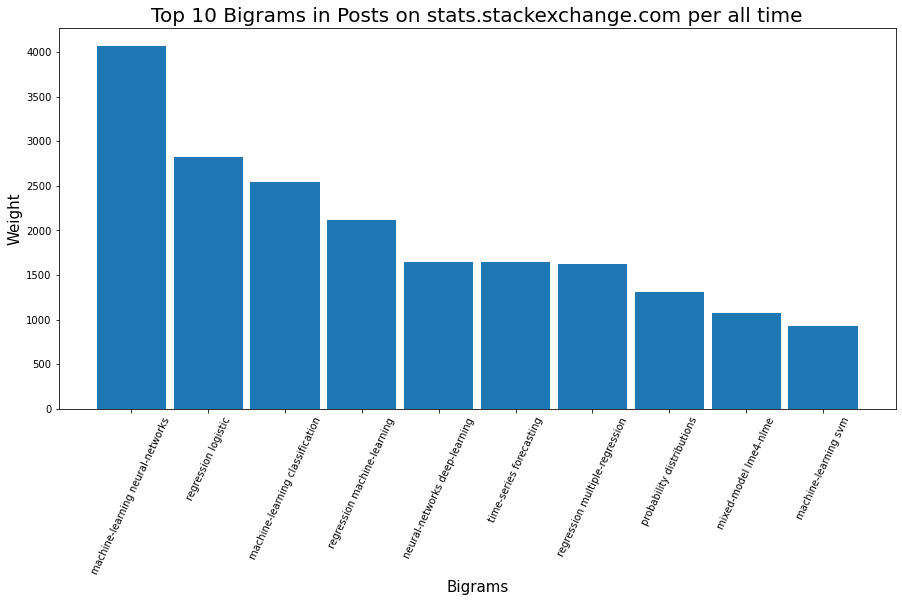

In [63]:
# поищем самые популярные биграммы и триграммы по весу 

project_id = 7
top = 10

data = data_request(f'SELECT "Tags","ViewCount","CreationDate" FROM public.posts WHERE "ProjectId" = {project_id} ;')
pub_date = data_request(f'SELECT "publication_date" FROM projects WHERE "id" = {project_id} ;')[0][0]
d_title = weight_dict_of_tags(data,pub_date,split_fun = lambda x: split_to_ngrams(x, 2, trash))
top_10 = list_of_popular_tags(d_title, top)

plot_hist_top_n(reform(top_10), project_id, ylabel = "Weight", xlabel = "Bigrams")

In [55]:
# среди топ 100 найти самые популярные по нашей метрике

In [56]:
# посчитать TF/IDF?

In [57]:
# завести в БД записи уже почищенных title


In [ ]:
# научиться считать на стороне БД вес тегов и получать оттуда словарь с весами